In [1]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.svm import LinearSVR
from sklearn import neighbors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import *
import joblib
from collections import defaultdict
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
from scipy import signal
import datetime
import csv
import os

from IPython.display import clear_output

import datetime
warnings.filterwarnings(action='ignore')

In [2]:
# 파일 호출하기

#    0: '0', # 전원 OFF
#    1: '1', # 송풍모드
#    2: '2', # 가온모드
#    3: '3', # 송풍+제습
#    4: '4', # 냉각
#    5: '5', # 냉각+제습
#    6: '6', # 가온+제습(사용 안함)

df = pd.read_feather('ecm_input.ftr')

In [3]:
col_list = [
    'f3_temp',
    'f10_temp','extemp',
    'entemp',
    'F_SET_MODE_0'
]

df_datetime = df['timestamp_min']
df_pre = df[col_list]
df_pre.index = df_datetime

df_pre['running'] = 1
df_pre['running'].loc[df_pre['F_SET_MODE_0'] == 1] = 0

df_pre.drop(['F_SET_MODE_0'],axis = 'columns', inplace = True)
df_pre

,f3_temp,f10_temp,extemp,entemp,running
timestamp_min,,,,,
2019-08-21 16:37:00,25.47,26.77,27.3,29.2,1
2019-08-21 16:38:00,25.47,26.77,27.1,29.2,1
2019-08-21 16:39:00,25.50,26.77,27.3,29.2,1
2019-08-21 16:40:00,25.60,26.77,27.5,29.2,1
2019-08-21 16:41:00,25.60,26.77,27.3,29.2,1
...,...,...,...,...,...
2019-10-24 23:55:00,23.62,22.32,20.8,19.9,0
2019-10-24 23:56:00,23.62,22.42,20.8,19.9,0
2019-10-24 23:57:00,23.62,22.42,20.8,19.9,0


In [4]:
# Linear Regressor 모델 생성

#train 시작과 종료 일자
start_date = datetime.date(2019,8,21)
end_date = datetime.date(2019,10,1)

df_train = df_pre[((pd.to_datetime(df_pre.index).date) >= (start_date)) & 
           ((pd.to_datetime(df_pre.index).date) < (end_date))]

# 모델 학습
Shift_Target = 10 # 10분 뒤에 학습함
model = MultiOutputRegressor(LinearRegression())
model.fit(df_train[:-Shift_Target], df_train[Shift_Target:]) # 학습 시 일부데이터는 학습 하지 않음

# 모델 저장
filename = "MPC_LR_Coef_.joblib"
joblib.dump(model, filename)
print(f"{filename} 에 ML 모델이 저장되었습니다.")


MPC_LR_Coef_.joblib 에 ML 모델이 저장되었습니다.


In [5]:
# LR 모델 불려오는 경우
path = 'MPC_LR_Coef_.joblib'
lr_model = joblib.load(path)

In [6]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [7]:
# 테스트 date 생성
# 우선 주석 처리함 - 하루 만 테스트 하기 위함
start_date = datetime.date(2019,8,22)
end_date = datetime.date(2019,10,1) # 11월 14일 테스트

# 날짜 array 생성
if (end_date-start_date).days == 0:
    end_date = start_date + datetime.timedelta(days=1)

Train_date_list = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days)]

# PID Gain setting
# 1차 테스트 게인 P, I, D = 1e-5, 1e-8, 0.001(PID Control)
# P Gain: 0.65e-16 -- 8월 23일 ~ 9월 30일(안함)
# P Gain : 0.1e-13 - 10월 1일 ~ 11월 14일 - 전부다 이거로 P 게인 진행함 
P, I, D = 1e-5, 1e-8, 0.001
ref_temp = 25.0

df_total = pd.DataFrame()

save_time = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
save_file_path = f"PID_result_{save_time}.csv"

for i in range(0, len(Train_date_list)):
    
    # clear output
    # clear_output(wait=True)
    
    Train_date = Train_date_list[i]
    print(Train_date)
    df_test_pre = df_pre[(pd.to_datetime(df_pre.index).date) == (Train_date)]
    
    # PID 계산 초기화
    integral = 0.
    derivative = 0.
    prev_error = 0.
    
    # 초기화
    x0=df_test_pre.iloc[0].to_numpy()
    # Dataframe
    PID_result = pd.DataFrame()
    
    for k in range(0, len(df_test_pre)-1):
        #f3_temp, f10_temp,extemp,running,entemp
        # print(k, end = ' ')
        # PID 계산
        error = x0[0] - ref_temp #desired state
            
        integral += error
        derivative = error - prev_error
        prev_error = error

        pid = P*error + I*integral + D*derivative
        #print(str(error) + str("  ") + str(pid))
        u0 = sigmoid(pid)
        u0 = np.round(u0).astype(np.int32)
    
        pre_x0 = pd.DataFrame([{
            'f3_temp': x0[0],
            'f10_temp': x0[1],
            'exttemp' : x0[2],
            'entemp' : df_test_pre['entemp'][k],
            'running' : u0,
        }])
        
        x0_output = model.predict(pre_x0)
        x0 = np.array(x0_output[0][0:3])
        
        PID_result = pd.concat([PID_result,pre_x0], ignore_index=True)

    # 내용 저장
    # 실제 운영된 것과 
    df_result = pd.DataFrame()
    df_result['timestamp'] = df_test_pre.index
    df_result['actural_x'] = pd.DataFrame(df_test_pre['f3_temp'].to_numpy())
    df_result['running'] = pd.DataFrame(df_test_pre['running'].to_numpy())
    df_result['pid_x'] = pd.DataFrame(PID_result['f3_temp'].to_numpy())
    df_result['pid_u'] = pd.DataFrame(PID_result['running'].to_numpy())
    
    df_total = pd.concat([df_total, df_result], ignore_index=None)
    
df_total.to_csv(save_file_path)

save_config = pd.DataFrame([{
            'datetime': save_time,
            'stardate': start_date,
            'enddate': end_date,
            'p': P,
            'i' : I,
            'd' : D
        }])

save_config = save_config.to_csv("save_config.csv", mode = 'a')

2019-08-22
2019-08-23
2019-08-24
2019-08-25
2019-08-26
2019-08-27
2019-08-28
2019-08-29
2019-08-30
2019-08-31
2019-09-01
2019-09-02
2019-09-03
2019-09-04
2019-09-05
2019-09-06
2019-09-07
2019-09-08
2019-09-09
2019-09-10
2019-09-11
2019-09-12
2019-09-13
2019-09-14
2019-09-15
2019-09-16
2019-09-17
2019-09-18
2019-09-19
2019-09-20
2019-09-21
2019-09-22
2019-09-23
2019-09-24
2019-09-25
2019-09-26
2019-09-27
2019-09-28
2019-09-29
2019-09-30


28.527913159060702


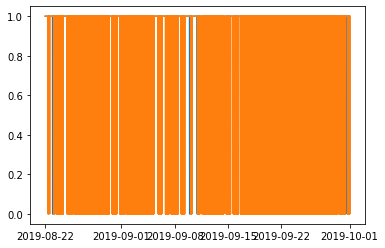

In [8]:
print((1-df_total['pid_u'].sum()/df_total['running'].sum().sum())*100)
plt.plot(df_total['timestamp'],df_total['running'])
plt.plot(df_total['timestamp'],df_total['pid_u'])

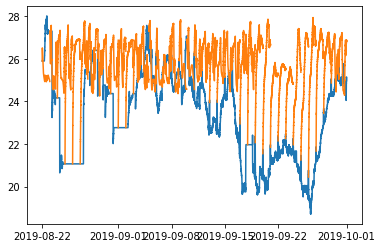

In [9]:
plt.plot(df_total['timestamp'],df_total['actural_x'])
plt.plot(df_total['timestamp'],df_total['pid_x'])